In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sb

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn import  metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV  #Perforing grid search

import matplotlib.pylab as plt

In [11]:
testOneHot = pd.read_csv('/home/leandro/Documentos/Organizacion de datos/Datos Pesados/210227_tp2_test_feng.csv')
trainOneHot = pd.read_csv('/home/leandro/Documentos/Organizacion de datos/Datos Pesados/210227_tp2_train_feng.csv')


testOneHot = testOneHot.drop(columns ="Unnamed: 0")
trainOneHot = trainOneHot.drop(columns ="Unnamed: 0")

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(trainOneHot.drop(columns = 'Stage'), trainOneHot['Stage'], test_size=0.2, random_state=123)


In [13]:
xg_reg = xgb.XGBRegressor(
                colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 50, alpha = 25, n_estimators = 100)


xg_reg.fit(X_train,y_train)



preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

xg_reg.score(X_test,y_test)

RMSE: 0.334591


0.5515726830790533

In [14]:
xg_reg = xgb.XGBRegressor(max_depth = 5,min_child_weight = 1,gamma = 0,subsample = 0.8
                          , colsample_bytree = 0.8,scale_pos_weight = 1 )


xg_reg.fit(X_train,y_train)



preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))
xg_reg.score(X_test,y_test)

RMSE: 0.322070


0.5845059160966137

In [15]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain["Stage"].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)#, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Stage'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print( "Accuracy : %.4g" % metrics.accuracy_score(dtrain['Stage'].values, dtrain_predictions))
    print( "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Stage'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
    feat_imp.head(10).plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [16]:
predictors = [x for x in trainOneHot.columns if x not in ["Stage"]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)


Model Report
Accuracy : 0.9758
AUC Score (Train): 0.997406


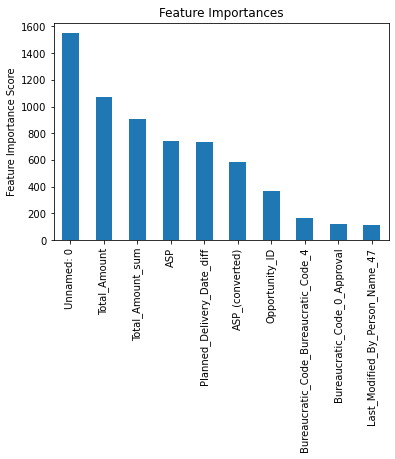

In [17]:
modelfit(xgb1, trainOneHot, predictors)

# Tune max_depth and min_child_weight

In [18]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(trainOneHot[predictors],trainOneHot["Stage"])

gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'mean_fit_time': array([ 37.96132865,  37.52665119,  37.56080813,  58.51632929,
          58.46666222,  59.12377377,  80.01790347,  79.73079734,
          79.86569114, 101.79607277, 102.02544141,  93.22696476]),
  'std_fit_time': array([ 0.81215452,  0.49998133,  0.34100798,  0.33012835,  0.35198232,
          0.6247008 ,  0.92109667,  0.9111795 ,  0.40554269,  0.45077737,
          0.5044607 , 11.53874538]),
  'mean_score_time': array([0.33750615, 0.38623028, 0.43302016, 0.43167739, 0.43355598,
         0.4091897 , 0.37901635, 0.42467418, 0.49406323, 0.44617758,
         0.44858465, 0.31347876]),
  'std_score_time': array([0.0598781 , 0.06635323, 0.07159416, 0.07471928, 0.03346594,
         0.05528409, 0.06653417, 0.05255345, 0.01220547, 0.04181966,
         0.04131733, 0.09042221]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False]

In [19]:

gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([ 37.96132865,  37.52665119,  37.56080813,  58.51632929,
          58.46666222,  59.12377377,  80.01790347,  79.73079734,
          79.86569114, 101.79607277, 102.02544141,  93.22696476]),
  'std_fit_time': array([ 0.81215452,  0.49998133,  0.34100798,  0.33012835,  0.35198232,
          0.6247008 ,  0.92109667,  0.9111795 ,  0.40554269,  0.45077737,
          0.5044607 , 11.53874538]),
  'mean_score_time': array([0.33750615, 0.38623028, 0.43302016, 0.43167739, 0.43355598,
         0.4091897 , 0.37901635, 0.42467418, 0.49406323, 0.44617758,
         0.44858465, 0.31347876]),
  'std_score_time': array([0.0598781 , 0.06635323, 0.07159416, 0.07471928, 0.03346594,
         0.05528409, 0.06653417, 0.05255345, 0.01220547, 0.04181966,
         0.04131733, 0.09042221]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False]

In [20]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(trainOneHot[predictors],trainOneHot["Stage"])
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'mean_fit_time': array([47.76903796, 47.20524249, 48.55128784, 58.41580453, 58.8877305 ,
         58.65454402, 68.78006229, 68.6558692 , 58.50417256]),
  'std_fit_time': array([ 0.8151399 ,  0.37421055,  0.46165504,  0.59362976,  0.27956825,
          0.58772381,  0.6215374 ,  0.73575335, 15.98070237]),
  'mean_score_time': array([0.37123828, 0.39295635, 0.40255332, 0.43442278, 0.4409297 ,
         0.41628232, 0.38759789, 0.38561516, 0.3183641 ]),
  'std_score_time': array([0.06587819, 0.12773404, 0.07286085, 0.06208985, 0.03649653,
         0.08138821, 0.07616717, 0.04768696, 0.1046329 ]),
  'param_max_depth': masked_array(data=[4, 4, 4, 5, 5, 5, 6, 6, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[4, 5, 6, 4, 5, 6, 4, 5, 6],
               mask=[False, False, False, False, False, False, False, False,
                    

In [21]:
param_test2b = {
 'min_child_weight':[6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=4,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(trainOneHot[predictors],trainOneHot["Stage"])

/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=4, min_child_weight=2,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27, subsample=0.8,
                                     tree_method=

In [22]:
#modelfit(gsearch3.best_estimator_, trainOneHot, predictors)
#gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_


Model Report
Accuracy : 0.8602
AUC Score (Train): 0.938701


({'mean_fit_time': array([48.30391641, 47.61711683, 47.53398614, 47.13289957]),
  'std_fit_time': array([0.54787308, 0.47248295, 0.5953419 , 0.57091136]),
  'mean_score_time': array([0.36942301, 0.32418504, 0.37635694, 0.34894238]),
  'std_score_time': array([0.06344989, 0.03131428, 0.05733904, 0.13129781]),
  'param_min_child_weight': masked_array(data=[6, 8, 10, 12],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'min_child_weight': 6},
   {'min_child_weight': 8},
   {'min_child_weight': 10},
   {'min_child_weight': 12}],
  'split0_test_score': array([0.89273399, 0.89277678, 0.89254404, 0.89359502]),
  'split1_test_score': array([0.78144954, 0.77887749, 0.79598962, 0.74391151]),
  'split2_test_score': array([0.77984018, 0.76770656, 0.75897655, 0.78062005]),
  'split3_test_score': array([0.8672191 , 0.86795666, 0.86653274, 0.86601039]),
  'split4_test_score': array([0.91688772, 0.91697705, 0.91409504, 0.90935908]),

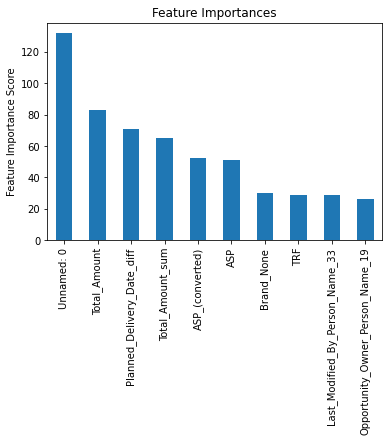

In [23]:
modelfit(gsearch2b.best_estimator_, trainOneHot, predictors)
gsearch2b.cv_results_, gsearch2b.best_params_, gsearch2b.best_score_

In [24]:
param_test1b = {
 'max_depth':range(10,60,10)},
 #'min_child_weight':range(1,6,2)}
gsearch1b = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1b.fit(trainOneHot[predictors],trainOneHot["Stage"])

gsearch1b.cv_results_, gsearch1b.best_params_, gsearch1b.best_score_

/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'mean_fit_time': array([113.57164721, 219.50429349, 275.76069398, 293.02343755,
         270.38061481]),
  'std_fit_time': array([ 0.62517294,  1.23330365,  5.20260513,  3.1649942 , 42.86272348]),
  'mean_score_time': array([0.32454329, 0.39730806, 0.43956819, 0.50145211, 0.36862106]),
  'std_score_time': array([0.05193415, 0.03353868, 0.06079766, 0.03017625, 0.14423261]),
  'param_max_depth': masked_array(data=[10, 20, 30, 40, 50],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_depth': 10},
   {'max_depth': 20},
   {'max_depth': 30},
   {'max_depth': 40},
   {'max_depth': 50}],
  'split0_test_score': array([0.86324935, 0.85747318, 0.84150873, 0.85833316, 0.8472061 ]),
  'split1_test_score': array([0.7575333 , 0.78268541, 0.77003623, 0.76192834, 0.78985621]),
  'split2_test_score': array([0.71046765, 0.7352421 , 0.74576167, 0.74429491, 0.74495255]),
  'split3_test_score': array([0.873247  , 0.87537766,

In [25]:
#Con max_depth  saco mejor score

# Tune gamma

In [26]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(trainOneHot[predictors],trainOneHot["Stage"])
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'mean_fit_time': array([48.50106969, 48.46684909, 48.21478744, 48.2872489 , 42.18192973]),
  'std_fit_time': array([ 0.28995612,  0.42278291,  0.67688737,  0.17935531, 13.48504509]),
  'mean_score_time': array([0.37230105, 0.37533412, 0.33310843, 0.34196277, 0.31383348]),
  'std_score_time': array([0.03316191, 0.08930673, 0.05822198, 0.04393531, 0.08682133]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.89273399, 0.89555607, 0.89907531, 0.8945124 , 0.8898326 ]),
  'split1_test_score': array([0.78144954, 0.7784429 , 0.78371601, 0.8091857 , 0.8091857 ]),
  'split2_test_score': array([0.77984018, 0.80674111, 0.78893792, 0.79072592, 0.7903164 ]),
  'split3_test_score': array([0.8672191 , 0.86657139, 0.86733454, 0.86771063, 0.8


Model Report
Accuracy : 0.937
AUC Score (Train): 0.984875


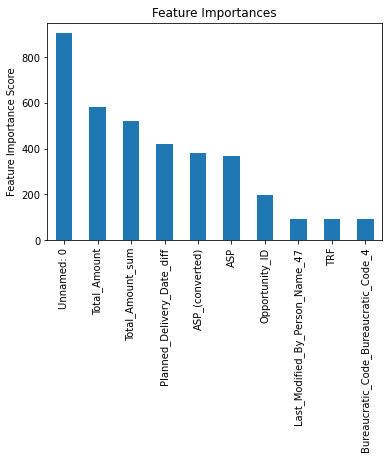

In [27]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, trainOneHot, predictors)

In [28]:
#ganma = 

# Tune subsample and colsample_bytree

In [ ]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(trainOneHot[predictors],trainOneHot["Stage"])
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

In [ ]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(trainOneHot[predictors],trainOneHot["Stage"])

In [ ]:
#{'colsample_bytree': , 'subsample': }, es la mejor score

# Tuning Regularization Parameters

In [ ]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(trainOneHot[predictors],trainOneHot["Stage"])
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

In [ ]:
param_test6b = {
 'reg_alpha':[110, 120, 130,140,150]
}
gsearch6b = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6b.fit(trainOneHot[predictors],trainOneHot["Stage"])
gsearch6b.cv_results_, gsearch6.best_params_, gsearch6.best_score_

In [ ]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(trainOneHot[predictors],trainOneHot["Stage"])
gsearch7.cv_results_, gsearch7.best_params_, gsearch7.best_score_

In [ ]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, trainOneHot, predictors)

In [ ]:
#Con reg_alpha =  mando el mejor score

# Reducing Learning Rate

In [ ]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=4,
 min_child_weight=5,
 gamma=0.3,
 subsample=0.7,
 colsample_bytree=0.7,
 reg_alpha=100,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, trainOneHot, predictors)

In [ ]:
prediccion = xgb4.predict_proba(testOneHot)
prediccion

In [ ]:
output = pd.DataFrame({'Opportunity_ID':testOneHot.Opportunity_ID, 'Target': prediccion[:,1]}) 
output

In [ ]:
final=output.groupby('Opportunity_ID').max()
final

In [ ]:
final.to_csv('/home/leandro/Documentos/Organizacion de datos/Fiuba-Big-Data-Analytics-TPs/Tp 2/Resultados/XGBoostScoreArchivosPesados.csv')